실습 1. Multithreaded Hello World
- 기본 버전
- mutex로 출력 제어 버전
- lambda 함수 버전

In [1]:
%%writefile hello_threads.cpp
#include <iostream>
#include <thread>
#include <vector>

using namespace std;

void hello(int id, int num_threads) {
  cout << "Hello from thread " << id << " of " << num_threads << endl;
}

int main(int argc, char** argv) {
  int num_threads = (argc > 1) ? stoi(argv[1]) : 4;

  // 이 부분을 채워서 작성하세요.
  vector<thread> ts;

  for (int i = 0; i < num_threads; i++) {
    ts.emplace_back(hello, i, num_threads);
  }

  for (auto& th: ts) th.join();

  return 0;
}

Writing hello_threads.cpp


In [2]:
!g++ -O2 -std=c++11 hello_threads.cpp -o hello_thread

In [3]:
!./hello_thread

Hello from thread 1 of 4
Hello from thread 0 of 4
Hello from thread Hello from thread 2 of 4
3 of 4


In [4]:
!./hello_thread 8

Hello from thread 0 of 8
Hello from thread Hello from thread 1 of 8
2 of 8
Hello from thread 3 of 8
Hello from thread 4 of 8
Hello from thread 5 of 8
Hello from thread 6 of 8
Hello from thread 7 of 8


In [5]:
%%writefile hello_threads_mutex.cpp
#include <iostream>
#include <thread>
#include <vector>
#include <mutex>

using namespace std;

mutex m;

void hello(int id, int num_threads) {
  // 이 부분에 lock_guard를 추가하세요.
  lock_guard<mutex> lock_guard(m);
  cout << "Hello from thread " << id << " of " << num_threads << endl;
}

int main(int argc, char** argv) {
  int num_threads = (argc > 1) ? stoi(argv[1]) : 4;

  // 이 부분을 채워서 작성하세요.
  vector<thread> ts;

  for (int t = 0; t < num_threads; t++) {
    ts.emplace_back(hello, t, num_threads);
  }
  for (auto &th : ts) th.join();
  return 0;
}

Writing hello_threads_mutex.cpp


In [6]:
!g++ -O2 -std=c++11 hello_threads_mutex.cpp -o hello_thread_mutex

In [7]:
!./hello_thread_mutex 8

Hello from thread 0 of 8
Hello from thread 2 of 8
Hello from thread 1 of 8
Hello from thread 3 of 8
Hello from thread 4 of 8
Hello from thread 6 of 8
Hello from thread 5 of 8
Hello from thread 7 of 8


In [8]:
%%writefile hello_threads_lambda.cpp
#include <iostream>
#include <thread>
#include <vector>
#include <mutex>

using namespace std;

mutex m;

int main(int argc, char** argv) {
  int num_threads = (argc > 1) ? stoi(argv[1]) : 4;
  vector<thread> ts;

  // lambda 함수 hello를 작성하세요.
  auto hello = [&](int id) -> void {
    lock_guard<mutex> lock_guard(m);
    cout << "Hello from thread " << id << " of " << num_threads << endl;
  }

  for (int t = 0; t < num_threads; t++) {
    ts.emplace_back(hello, t);
  }
  for (auto &th : ts) th.join();
  return 0;
}

Writing hello_threads_lambda.cpp


In [9]:
!g++ -O2 -std=c++11 hello_threads_mutex.cpp -o hello_thread_lambda

In [10]:
!./hello_thread_lambda 8

Hello from thread 0 of 8
Hello from thread 3 of 8
Hello from thread 1 of 8
Hello from thread 4 of 8
Hello from thread 2 of 8
Hello from thread 5 of 8
Hello from thread 6 of 8
Hello from thread 7 of 8


실습 2. DMV 분배 전략 비교

In [11]:
%%writefile dmv.cpp
// Usage_examples:
// !./dmv 1024 1024 8 block              // n_row n_col n_threads dist_method
// !./dmv 1024 1024 8 cyclic             // n_row n_col n_threads dist_method
// !./dmv 1024 1024 8 block_cyclic 64    // n_row n_col n_threads dist_method chunk_size

#include <iostream>
#include <thread>
#include <vector>
#include <cstring>

using namespace std;

void init(vector<double>& A, int m, bool zero) {
  for (int i = 0; i < m; i++) {
    A[i] = zero ? 0 : rand() / double(RAND_MAX);
  }
}

int main(int argc, char** argv) {
  if (argc < 5) {
    cerr << "Missing arguments!" << endl;
  }
  int m = stoi(argv[1]);
  int n = stoi(argv[2]);
  int num_threads = stoi(argv[3]);
  string strategy = argv[4];
  int chunk = (argc > 5) ? stoi(argv[5]) : 1;
  vector<double> A(m*n);
  vector<double> x(n);
  vector<double> b(m);
  init(A, m*n, false);
  init(x, n, false);
  init(b, m, true);
  vector<thread> ts;

  auto start = chrono::high_resolution_clock::now();

  if (strategy == "block") {
    // 이 부분을 채우세요.
    chunk = (m + num_threads - 1) / num_threads;

    auto block = [&](const int id) -> void {
      int lower = id * chunk;
      int upper = min(lower + chunk, m);

      for (int row = lower; row < upper; row++) {
        double acc = 0;
        for (int col = 0; col < n; col++) {
          acc += A[row*n + col] * x[col];
        }
        b[row] = acc;
      }
    };

    for (int t = 0; t < num_threads; t++) {
      ts.emplace_back(block, t);
    }

    for (auto& th: ts) th.join();
  }
  else if (strategy == "cyclic") {
    // 이 부분을 채우세요.
    auto cyclic = [&](const int id) -> void {
      for (int row = id; row < m; row += num_threads) {
        double acc = 0;
        for (int col = 0; col < n; col++) {
          acc += A[row*n + col] * x[col];
        }
        b[row] = acc;
      }
    };

    for (int t = 0; t < num_threads; t++) {
      ts.emplace_back(cyclic, t);
    }

    for (auto& th: ts) th.join();
  }
  else if (strategy == "block_cyclic") {
    // 이 부분을 채우세요.
    auto block_cyclic = [&](int id) -> void {
      int offset = id*chunk;
      int stride = chunk * num_threads;

      for (int lower = offset; lower < m;  lower += stride) {
        int upper = min(lower + chunk, m);
        for (int row = lower; row < upper; row++) {
          double acc = 0;
          for (int col = 0; col < n; col++) {
            acc += A[row*n+col]*x[col];
          }
          b[row] = acc;
        }
      }
    };

    for (int t = 0; t < num_threads; t++) {
      ts.emplace_back(block_cyclic, t);
    }

    for (auto& th: ts) th.join();
  }
  else {
    cerr << "Unknown strategy!" << endl;
  }

  auto end = chrono::high_resolution_clock::now();
  chrono::duration<double> diff = end - start;
  cout << "Execution time: " << diff.count() << " s" << endl;
  cout << "b[0]: " << b[0] << endl;
  return 0;
}

Writing dmv.cpp


In [12]:
!g++ -O2 -std=c++11 dmv.cpp -o dmv

In [13]:
!./dmv 1024 1024 8 block
!./dmv 1024 1024 8 cyclic
!./dmv 1024 1024 8 block_cyclic 64

Execution time: 0.0005043 s
b[0]: 264.403
Execution time: 0.00057244 s
b[0]: 264.403
Execution time: 0.00056842 s
b[0]: 264.403


# 실습2 보고서(해당 칸에 다음의 내용을 기재하시오)
1. matrix 크기 1024x1024, thread 수 8개로 고정한 상태에서
block_cyclic의 chunk 크기를 변화시켜가며 성능 변화를 측정해볼 것.

- 아주 작은 사이즈(1)부터, 아주 큰 사이즈(1024/8=128)까지 변화시켜보며, 성능 측정한 결과를 이 칸에 reporting하고, 간단한 분석을 이 칸에 기재하시오.

# 김준호 - 실습2 보고서
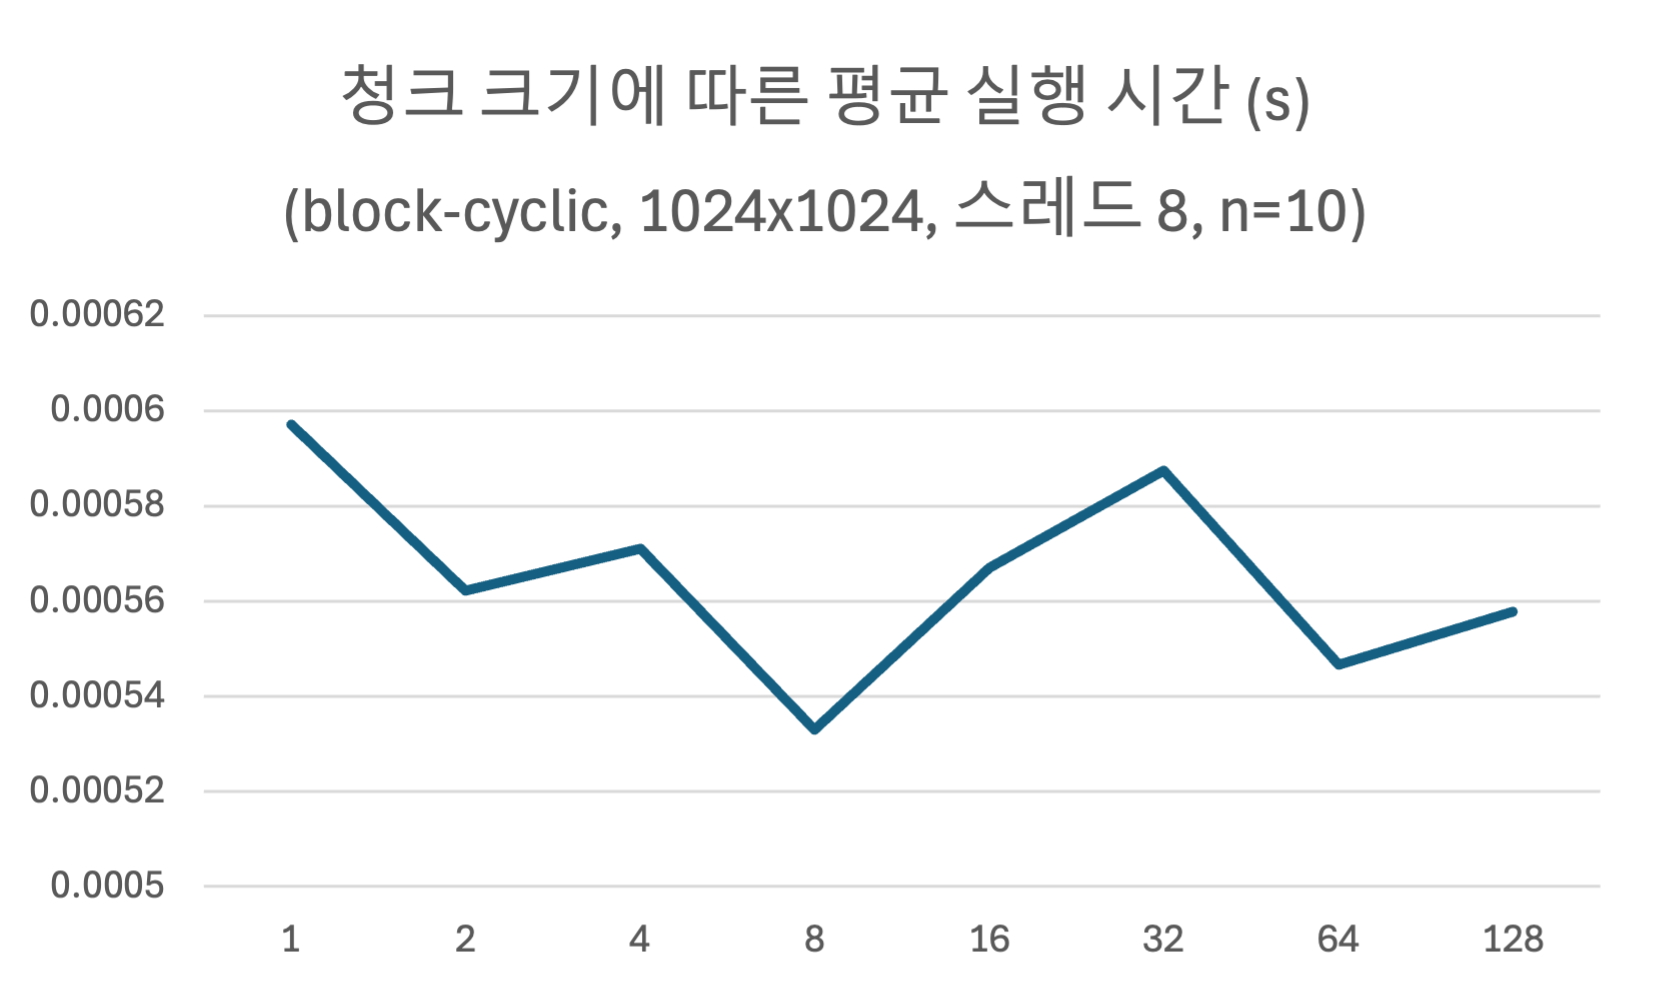

## 실험 조건

- 행렬 크기: 1024x1024
- 스레드 수: 8
- 분할 방법: block-cyclic
- chunk = 1, 2, 4, 8, 16, 32, 64, 128
- 각 조건 10회 반복 측정 후 평균 사용 (n=10)
- 런타임 유형: v5e-1 TPU

## 결과 요약

- 최소 실행 시간: chunk 8에서 0.00053306초
- 최대 실행 시간: chunk 1에서 0.00059707초

## 분석

1. chunk = 1 (Cyclic / Round-Robin 분할)

로드(load)는 균등하지만, 8개의 스레드가 같은 시점에 b[0..7], b[8..15]처럼 같은 캐시라인의 서로 다른 원소를 update 사건이 발생할 수 있으므로 false sharing 비용이 존재한다. 또한 한 스레드의 다음에 처리할 행이 row+8로 건너뛰어서 연속 행 처리가 끊기므로 Locality 이점이 적다. 따라서, 실험 결과, 0.00059707초로 가장 느렸다.

1. chunk = 128 (Block 분할)

각 스레드가 큰 연속된 구간을 맡아 처리하므로 벡터 b에 대한 false sharing이 크게 감소하고, Locality가 좋다. 따라서, 실험 결과, 0.00055792초로 chunk=1 대비 6.56% 단축되었다.

1. chunk = 8 (이번 실험 최적)

chunk=8은 64 bits 컴퓨터에서 캐시라인 크기와 정확히 맞아서 각 스레드가 캐시 라인 단위로 벡터 b의 write한다. 캐시 친화적이다. 따라서 실험 결과, 0.00053306초로 가장 빨랐다. chunk=1 대비 10.72% 단축되었고 chunk=128 대비 4.46% 단축되었다.

## 참고 자료
각 조건 10회 반복 측정 후 얻은 평균 값
- chunk=1: 0.00059707
- chunk=2: 0.00056225
- chunk=4: 0.00057106
- chunk=8: 0.00053306
- chunk=16: 0.00056715
- chunk=32: 0.00058742
- chunk=64: 0.00054658
- chunk=128: 0.00055792


HW2: BigInt Multiplication


In [14]:
%%writefile bigint_mul.cpp
#include <iostream>
#include <cstring>
#include <cstdint>
#include <cstdio>
#include <cstdlib>
#include <ctime>
#include <chrono>
#include <vector>
#include <thread>

using namespace std;

#define N_LIMBS 16384

struct bigint {
  uint32_t limbs[N_LIMBS];
  bigint(){ memset(limbs, 0, sizeof(limbs)); }
  void randomize(){
    for(int i=0;i<N_LIMBS;i++){
      limbs[i] = rand();
    }
  }
  void print_hex() const{
    for(int i=N_LIMBS-1;i>=0;i--) printf("%08x", limbs[i]);
    printf("\n");
  }
};

struct bigint_long {
  uint32_t limbs[2*N_LIMBS];
  bigint_long(){ memset(limbs, 0, sizeof(limbs)); }
  void print_hex() const{
    for(int i=2*N_LIMBS-1;i>=0;i--) printf("%08x", limbs[i]);
    printf("\n");
  }
};

// Sequential 버전
void bigmul_sequential(const bigint &a, const bigint &b, bigint_long &c){
  memset(c.limbs, 0, sizeof(c.limbs)); // 결과를 저장할 c를 0으로 초기화
  for(int i=0;i<N_LIMBS;i++){
    uint64_t carry = 0;
    for(int j=0;j<N_LIMBS;j++){
      // a.limbs[i]와 b.limbs[j]를 곱해서 c.limbs[i+j]에 저장
      // 32비트 크기의 두 limb를 곱하면 64비트 결과물이 필요하므로, 사전에 64비트로 casting하여 연산
      // 결과를 저장할 c 역시 32비트 array로 이루어져있기 때문에, 연산 결과 64비트 중 상위 32bit는 carry로 처리하여 다음 j iteration에서 처리하도록 함
      // 또한, 하나의 c.limbs[n]은 i+j = n이 되는 모든 i,j 쌍의 결과를 합해야하기 때문에 누적시켜나가야함.
      uint64_t s = (uint64_t)c.limbs[i+j]
                 + (uint64_t)a.limbs[i]*(uint64_t)b.limbs[j]
                 + carry;
      c.limbs[i+j] = (uint32_t)s;
      carry = s >> 32;
    }
    // j = N_LIMBS-1 까지 도달했는데, carry가 남아있다면, 다음 limb인 c.limbs[i+N_LIMBS] 쪽으로 carry 전파
    int k = i + N_LIMBS;
    while(carry && k < 2*N_LIMBS){ // carry 전파 과정에서 carry가 다시 발생하면 가장 상위 limb까지 carry 연쇄 전파
      uint64_t s = (uint64_t)c.limbs[k] + carry;
      c.limbs[k] = (uint32_t)s;
      carry = s >> 32;
      ++k;
    }
  }
}

// Parallel 버전
void bigmul_parallel(const bigint &a, const bigint &b, bigint_long &c, int num_threads)
{
  if(num_threads < 1) num_threads = 1;
  memset(c.limbs, 0, sizeof(c.limbs));

  // 이 부분을 채우세요.

  // 구현 참고
  // - 이 문제의 경우, a나 b 중 하나를 chunk 단위로 나눠서 여러 thread에게 나눠주는 방법이 가장 간편하고 용이함. (즉, block distribution: thread마다 서로 다른 i index 할당)
  // - 다만, 각 thread가 결과 update를 위해 c.limbs에 접근할 때 다른 thread와 race condition이 발생할 수 있으므로 이를 잘 처리해줘야함.
  // - thread마다 local하게 임시 bigint_long을 만들어서 저장후 최종 업데이트 하는 방법 vs. mutex로 접근 제어하는 방법 등을 잘 고려해보아야 함.

  vector<bigint_long> locals(num_threads);

  auto block = [&](const int id) -> void {
    int chunk = (N_LIMBS + num_threads - 1) / num_threads;
    int lower = id * chunk;
    int upper = min(lower + chunk, N_LIMBS);
    bigint_long& cl = locals[id];

    for (int i = lower; i < upper; i++){
      uint64_t carry = 0;
      for (int j = 0; j < N_LIMBS; j++) {
        uint64_t s = (uint64_t)cl.limbs[i+j]
                    + (uint64_t)a.limbs[i]*(uint64_t)b.limbs[j]
                    + carry;
        cl.limbs[i+j] = (uint32_t)s;
        carry = s >> 32;
      }

      int k = i + N_LIMBS;
      while(carry && k < 2 * N_LIMBS) {
        uint64_t s = (uint64_t)cl.limbs[k] + carry;
        cl.limbs[k] = (uint32_t)s;
        carry = s >> 32;
        ++k;
      }
    }
  };

  vector<thread> ts;

  for (int t = 0; t < num_threads; t++) {
    ts.emplace_back(block, t);
  }

  for (auto &th: ts) {
    th.join();
  }

  vector<uint64_t> acc(2 * N_LIMBS, 0);
  for (int id = 0; id < num_threads; id++) {
    const bigint_long &cl = locals[id];
    for (int i = 0; i < 2 * N_LIMBS; i++) {
      acc[i] += (uint64_t)cl.limbs[i];
    }
  }

  uint64_t carry = 0;
  int k = 0;
  while(k < 2 * N_LIMBS) {
    uint64_t s = acc[k] + carry;
    c.limbs[k] = (uint32_t)s;
    carry = s >> 32;
    k++;
  }
}

int main(int argc, char** argv){
  int num_threads = (argc > 1) ? stoi(argv[1]) : 4;
  bigint a, b;
  bigint_long c_seq, c_par;
  a.randomize();
  b.randomize();

  auto t0 = std::chrono::high_resolution_clock::now();
  bigmul_sequential(a, b, c_seq);
  auto t1 = std::chrono::high_resolution_clock::now();

  auto t2 = chrono::high_resolution_clock::now();
  bigmul_parallel(a, b, c_par, num_threads);
  auto t3 = chrono::high_resolution_clock::now();
  // 아래 line을 통해서 입력 a, b와 결과 c를 출력할 수 있음.
  //a.print_hex();
  //b.print_hex();
  //c_seq.print_hex();

  // 결과 체크
  bool ok = true;
  for (int i = 0; i < 2*N_LIMBS; i++) {
    if (c_seq.limbs[i] != c_par.limbs[i]) {
      ok = false;
      break;
    }
  }

  double seq_sec = std::chrono::duration<double>(t1 - t0).count();
  double par_sec = std::chrono::duration<double>(t3 - t2).count();
  cout << "[Sequential] " << seq_sec << endl;
  cout << "[Parallel w/ " << num_threads << " threads] " << par_sec << endl;
  cout << "Correctness " << (ok ? "OK" : "MISMATCH") << endl;

  return 0;
}

Writing bigint_mul.cpp


In [15]:
!g++ -std=c++11 -O2 bigint_mul.cpp -o bigint_mul

In [16]:
!./bigint_mul 8

[Sequential] 0.170516
[Parallel w/ 8 threads] 0.0230725
Correctness OK


# HW2 보고서(해당 칸에 다음의 내용을 기재하시오)
1) bigmul_sequential()에 있는 내용 중 **어떤 부분**을 **어떻게** 병렬화하여 bigmul_parallel을 만들었는지 상세히 기술하시오.

2) 런타임세션을 v5e-1 TPU로 변경하고 bigint_mul을 8 threads로 실행했을 때, 실험 결과 sequential 대비 8 threads가 성능이 얼마나 향상되는지 기술하시오.

# 김준호 - HW2 보고서

## 1번 문항

### 메인 아이디어(병렬화 전략)
bigmul_sequential()에서 한 자리(limb 인덱스) `k = i + j`에 대해 부분곱을 누적한다.

```c++
uint64_t s = (uint64_t)c.limbs[i+j]
            + (uint64_t)a.limbs[i]*(uint64_t)b.limbs[j]
            + carry;
c.limbs[i+j] = (uint32_t)s;
```
밑 B=$2^{32}$에서 $c[k]=\sum_{i+j=k} a[i]\cdot b[j]$이므로, 인덱스 i로 부분합을 나눠 계산한 뒤 합쳐도 결과는 동일하다. 이에 따라 다음 전략을 사용했다.

- 바깥 i 루프를 스레드별 block 분할로 나눈다.
- 각 스레드는 자기 구간의 i에 대한 결과를 임시 bigint_long에 누적한다(로컬 내부에서 carry 전파 포함).
- 모든 스레드가 끝나면 로컬 버퍼들을 자리별로 합산하고, 마지막에 한 번만 carry를 전파하여 최종 c를 완성한다 (계산 단계에서 race condition 없음).

### 병렬화 과정

1. 병렬화 대상 loop 및 block 분할

```c++
// Sequential
for(int i = 0; i < N_LIMBS; i++)
```

i를 block 분할:

```c++
// Parallel
int chunk = (N_LIMBS + num_threads - 1) / num_threads;
int lower = id * chunk;
int upper = min(lower + chunk, N_LIMBS);
```

각 스레드는 $[lower, upper)$까지 담당한다.

2. c에 바로 저장하지 않고 각 스레드는 임시 bigint_long에 누적

Sequential 버전은 c[i+j]를 직접 update한다.

```c++
// Sequential
uint64_t s = (uint64_t)c.limbs[i+j]
            + (uint64_t)a.limbs[i]*(uint64_t)b.limbs[j]
            + carry;
c.limbs[i+j] = (uint32_t)s;
carry = s >> 32;
```

Parallel 버전은 스레드별 임시 bigint_long cl에 누적하여 race condition을 방지한다.

```c++
// Parallel
uint64_t s = (uint64_t)cl.limbs[i+j]
            + (uint64_t)a.limbs[i]*(uint64_t)b.limbs[j]
            + carry;  
cl.limbs[i+j] = (uint32_t)s;
carry = s >> 32;
```

이 과정은 lock 없이 진행된다.

3. carry 전파 (로컬에서 처리)
Sequential 버전은 각 i 처리 후 남은 carry를 c의 상위 자리로 곧바로 전파한다.

```c++
// Sequential
int k = i + N_LIMBS;
while(carry && k < 2 * N_LIMBS){
  uint64_t s = (uint64_t)c.limbs[k] + carry;
  c.limbs[k] = (uint32_t)s;
    carry = s >> 32;
  ++k;
}
```

Parallel 버전은 동일 과정을 각 스레드 로컬 cl에 적용한다.

```c++
// Parallel
int k = i + N_LIMBS;
while(carry && k < 2 * N_LIMBS) {
  uint64_t s = (uint64_t)cl.limbs[k] + carry;
  cl.limbs[k] = (uint32_t)s;
  carry = s >> 32;
  ++k;
}
```

각 로컬 버퍼는 32비트로 정규화 되어 있다.

4. 자리별 병합 및 최종 캐리

모든 스레드의 로컬 cl을 자리 별로 합산한다.
```c++
// Parallel
vector<uint64_t> acc(2 * N_LIMBS, 0);
for (int id = 0; id < num_threads; id++) {
  const bigint_long &cl = locals[id];
  for (int i = 0; i < 2 * N_LIMBS; i++) {
    acc[i] += (uint64_t)cl.limbs[i];
  }
}
```

그 후 전체에 대해 한 번만 carry 전파를 수행한다.

```c++
// Parallel
uint64_t carry = 0;
int k = 0;
while(k < 2 * N_LIMBS) {
  uint64_t s = acc[k] + carry;
  c.limbs[k] = (uint32_t)s;
  carry = s >> 32;
  k++;
}
```

동일한 자리 k에서 스레드별 로컬 결과를 계속 더해 가면 중간에 합이 $2^{32} - 1$을 넘을 수 있으므로, 그 값을 저장하는 변수는 64비트 정수로 둔다. 이렇게 하면 자리별 합산 과정에서 값이 32비트를 초과해도 문제 없이 계산된다. 그리고 carry 전파는 모든 자리의 합산이 끝난 뒤에 한 번만 수행된다. 컨볼루션 합을 먼저 확정하고 나서 일괄 자리올림을 처리하면 구현이 단순해지고, 단계별 carry를 반복 수행하면서 생기는 오버헤드를 줄일 수 있다.

## 2번 문항

### 실험 조건

- 스레드 수: 8
- 분할 방법: block 분할
- 런타임 유형: v5e-1 TPU

### 실험 결과

```bash
[Sequential] 0.170516
[Parallel w/ 8 threads] 0.0230725
```

- $T_{seq}$ = 0.170516
- $T_{par}$ = 0.0230725


### 분석

- Speedup $S = T_{seq} / T_{par} = 0.170516 / 0.0230725 \approx\ 7.39$
- Efficiency $E = S / 8 \approx\ 7.39 / 8 = 92.4%$
- Cost $C = T_{par} \times 8 = 0.0230725 \times 8 \approx\ 0.18458$

결론: 8개 스레드에서 Sequential 대비 약 7.39배 성능 향상을 확인했다.

제출 가이드

제출물: 본 ipynb 파일

다운로드: 파일 -> 다운로드 -> .ipynb 다운로드

제출기한: 2025/11/10 (월) 23:59

**주의사항: 제출 전에 모든 결과물은 v5e-1 TPU 런타임 세션에서 한 번 실행된 상태여야 함. 런타임세션을 v5e-1 TPU로 바꾸고, 화면 상단의 모두 실행을 눌러서, 전체가 잘 실행되었는지 확인하고, 해당 실행 결과가 포함된 채로 제출하시오.**